In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
import random
import tensorflow as tf

In [3]:
data_path = "data/data_clf/"

In [4]:
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,
                                                            validation_split=0.3,
                                                            horizontal_flip=True,
                                                            vertical_flip=True)

image_data_train = image_gen.flow_from_directory(directory=data_path,
                                           target_size=(224, 224),
                                           classes=[f"A{i}" for i in range(1, 21)],
                                           class_mode="categorical", 
                                           subset="training")

image_data_val = image_gen.flow_from_directory(directory=data_path,
                                           target_size=(224, 224),
                                           classes=[f"A{i}" for i in range(1, 21)],
                                           class_mode="categorical", 
                                           subset="validation")

Found 15648 images belonging to 20 classes.
Found 6693 images belonging to 20 classes.


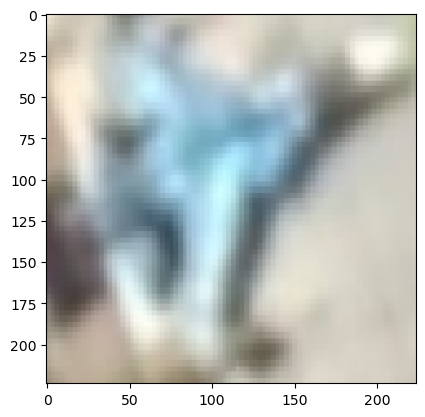

In [5]:
plt.imshow(image_data_train[0][0][7])

In [7]:
pretrained_model = tf.keras.applications.MobileNet(include_top=False,
                                                   input_shape=(224, 224, 3),
                                                   classes=20)
for layer in pretrained_model.layers:
    layer.trainable = False

In [8]:
pretrained_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [19]:
model_clf = tf.keras.Sequential([pretrained_model,
                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.he_normal),
                                 tf.keras.layers.Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.he_normal),
                                 tf.keras.layers.Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.he_normal),
                                 tf.keras.layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal),
                                 tf.keras.layers.Dense(20, activation="softmax")
                                ])

model_clf.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.categorical_crossentropy,
                  metrics=["acc", "Precision", "Recall"])

In [25]:
model_clf = tf.keras.models.load_model("runs/clf/core_model.h5")

In [21]:
model_clf.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 50176)             0         
                                                                 
 dense_15 (Dense)            (None, 128)               6422656   
                                                                 
 dense_16 (Dense)            (None, 128)               16512     
                                                                 
 dense_17 (Dense)            (None, 128)               16512     
                                                                 
 dense_18 (Dense)            (None, 32)                4128      
                                                      

In [22]:
history = model_clf.fit(image_data_train, validation_data=image_data_val, epochs=10)

Epoch 1/10
489/489 [==============================] - 254s 518ms/step - loss: 2.0115 - acc: 0.4410 - precision: 0.7585 - recall: 0.2772 - val_loss: 1.1624 - val_acc: 0.6626 - val_precision: 0.7734 - val_recall: 0.5598
Epoch 2/10
489/489 [==============================] - 255s 522ms/step - loss: 0.6178 - acc: 0.8012 - precision: 0.8531 - recall: 0.7600 - val_loss: 0.6785 - val_acc: 0.8001 - val_precision: 0.8263 - val_recall: 0.7798
Epoch 3/10
489/489 [==============================] - 255s 521ms/step - loss: 0.3431 - acc: 0.8870 - precision: 0.9054 - recall: 0.8726 - val_loss: 0.6437 - val_acc: 0.8279 - val_precision: 0.8489 - val_recall: 0.8143
Epoch 4/10
489/489 [==============================] - 255s 522ms/step - loss: 0.2475 - acc: 0.9204 - precision: 0.9299 - recall: 0.9117 - val_loss: 0.5475 - val_acc: 0.8509 - val_precision: 0.8675 - val_recall: 0.8395
Epoch 5/10
489/489 [==============================] - 254s 520ms/step - loss: 0.2139 - acc: 0.9320 - precision: 0.9414 - recall:

In [23]:
model_clf.save("runs/clf/core_model.h5")

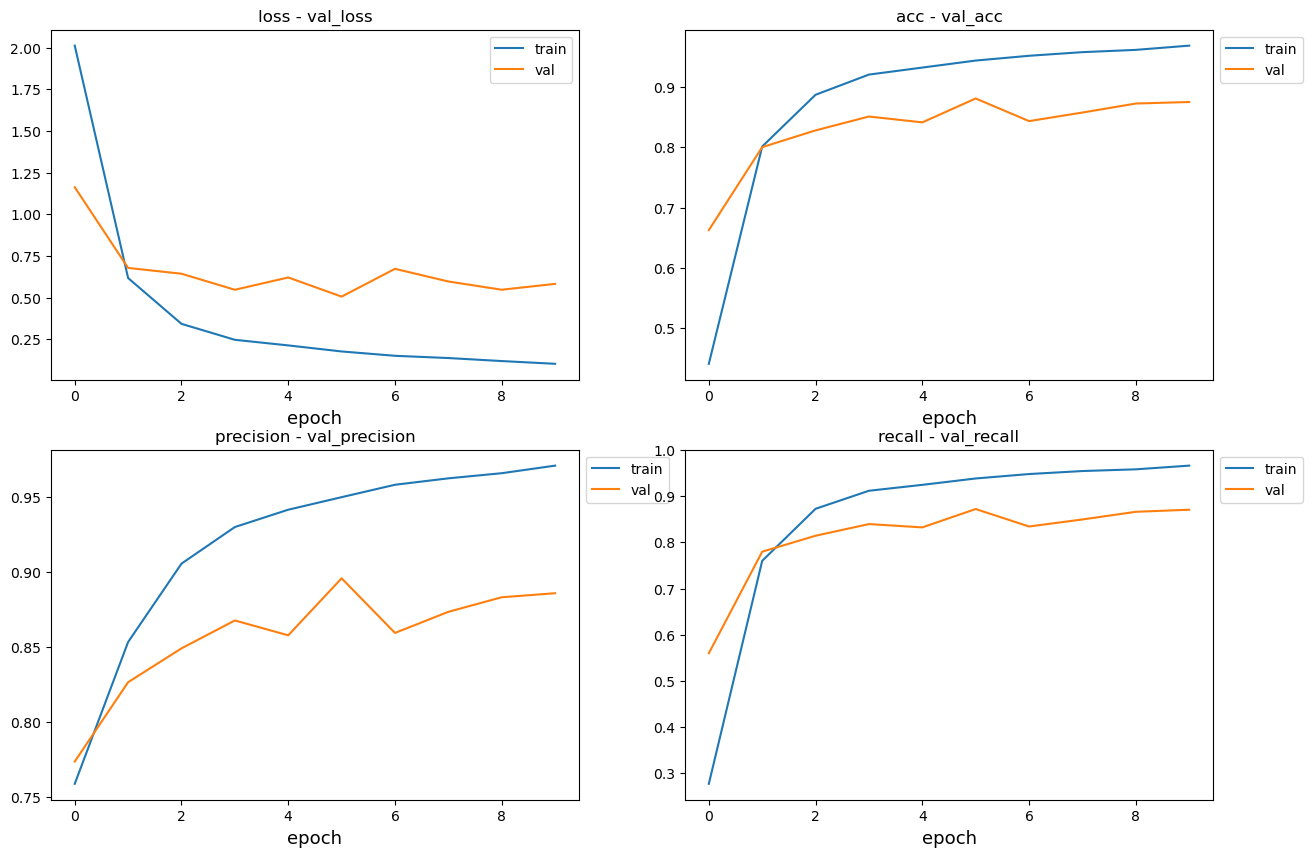

In [24]:
# plotting the history of training
fig, axis = plt.subplots(2, 2, figsize=(15, 10))

axis[0, 0].plot(history.history["loss"], label="train")
axis[0, 0].plot(history.history["val_loss"], label="val")
axis[0, 0].set_title("loss - val_loss")
axis[0, 0].set_xlabel("epoch", fontsize=13)
axis[0, 0].legend(bbox_to_anchor=(1.0, 1.0))


axis[0, 1].plot(history.history["acc"], label="train")
axis[0, 1].plot(history.history["val_acc"], label="val")
axis[0, 1].set_title("acc - val_acc")
axis[0, 1].set_xlabel("epoch", fontsize=13)
axis[0, 1].legend(bbox_to_anchor=(1.0, 1.0))

axis[1, 0].plot(history.history["precision"], label="train")
axis[1, 0].plot(history.history["val_precision"], label="val")
axis[1, 0].set_title("precision - val_precision")
axis[1, 0].set_xlabel("epoch", fontsize=13)
axis[1, 0].legend(bbox_to_anchor=(1.0, 1.0))


axis[1, 1].plot(history.history["recall"], label="train")
axis[1, 1].plot(history.history["val_recall"], label="val")
axis[1, 1].set_title("recall - val_recall")
axis[1, 1].set_xlabel("epoch", fontsize=13)
axis[1, 1].legend(bbox_to_anchor=(1.0, 1.0))


plt.show()

In [28]:
model_clf = tf.keras.Sequential([pretrained_model,
                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.he_normal),
                                 tf.keras.layers.Dropout(0.1),
                                 tf.keras.layers.Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.he_normal),
                                 tf.keras.layers.Dropout(0.1),
                                 tf.keras.layers.Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.he_normal),
                                 tf.keras.layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal),
                                 tf.keras.layers.Dense(20, activation="softmax")
                                ])

model_clf.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.categorical_crossentropy,
                  metrics=["acc", "Precision", "Recall"])

In [27]:
model_clf = tf.keras.models.load_model("runs/clf/core_model.h5")

In [29]:
model_clf.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 50176)             0         
                                                                 
 dense_25 (Dense)            (None, 128)               6422656   
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_26 (Dense)            (None, 128)               16512     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                      

In [30]:
history = model_clf.fit(image_data_train, validation_data=image_data_val, epochs=10)

Epoch 1/10
489/489 [==============================] - 266s 541ms/step - loss: 2.7338 - acc: 0.2060 - precision: 0.5670 - recall: 0.0695 - val_loss: 1.2712 - val_acc: 0.6033 - val_precision: 0.7684 - val_recall: 0.4393
Epoch 2/10
489/489 [==============================] - 261s 534ms/step - loss: 0.9165 - acc: 0.6884 - precision: 0.7926 - recall: 0.6102 - val_loss: 0.6725 - val_acc: 0.7784 - val_precision: 0.8458 - val_recall: 0.7303
Epoch 3/10
489/489 [==============================] - 264s 540ms/step - loss: 0.5864 - acc: 0.8025 - precision: 0.8592 - recall: 0.7630 - val_loss: 0.6088 - val_acc: 0.8017 - val_precision: 0.8475 - val_recall: 0.7671
Epoch 4/10
489/489 [==============================] - 273s 560ms/step - loss: 0.4840 - acc: 0.8417 - precision: 0.8855 - recall: 0.8122 - val_loss: 0.5473 - val_acc: 0.8309 - val_precision: 0.8729 - val_recall: 0.7940
Epoch 5/10
489/489 [==============================] - 294s 601ms/step - loss: 0.4185 - acc: 0.8677 - precision: 0.9025 - recall:

In [31]:
model_clf.save("runs/clf/core_model.h5")

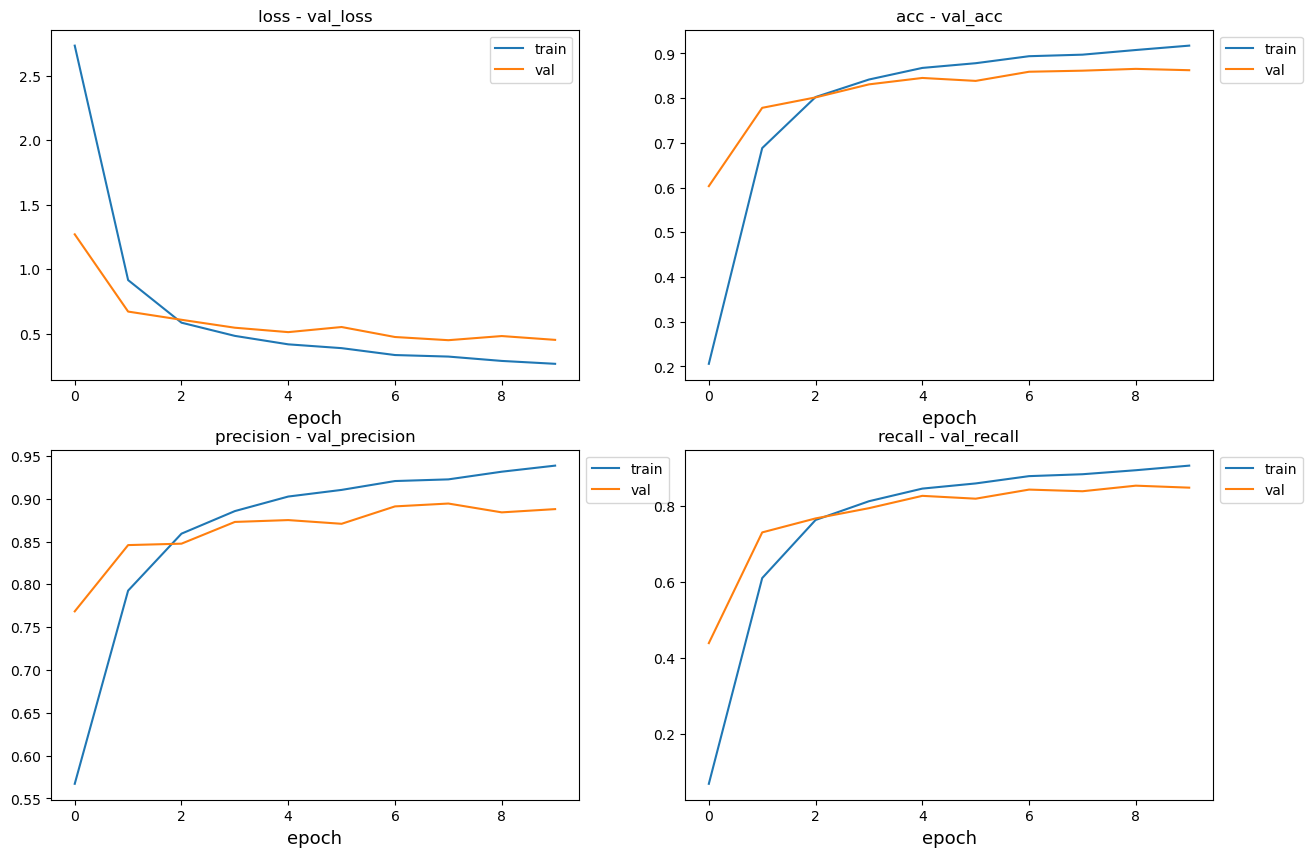

In [32]:
# plotting the history of training
fig, axis = plt.subplots(2, 2, figsize=(15, 10))

axis[0, 0].plot(history.history["loss"], label="train")
axis[0, 0].plot(history.history["val_loss"], label="val")
axis[0, 0].set_title("loss - val_loss")
axis[0, 0].set_xlabel("epoch", fontsize=13)
axis[0, 0].legend(bbox_to_anchor=(1.0, 1.0))


axis[0, 1].plot(history.history["acc"], label="train")
axis[0, 1].plot(history.history["val_acc"], label="val")
axis[0, 1].set_title("acc - val_acc")
axis[0, 1].set_xlabel("epoch", fontsize=13)
axis[0, 1].legend(bbox_to_anchor=(1.0, 1.0))

axis[1, 0].plot(history.history["precision"], label="train")
axis[1, 0].plot(history.history["val_precision"], label="val")
axis[1, 0].set_title("precision - val_precision")
axis[1, 0].set_xlabel("epoch", fontsize=13)
axis[1, 0].legend(bbox_to_anchor=(1.0, 1.0))


axis[1, 1].plot(history.history["recall"], label="train")
axis[1, 1].plot(history.history["val_recall"], label="val")
axis[1, 1].set_title("recall - val_recall")
axis[1, 1].set_xlabel("epoch", fontsize=13)
axis[1, 1].legend(bbox_to_anchor=(1.0, 1.0))


plt.show()